In [20]:
import pandas as pd

## 平滑化チェック

In [21]:
# ▼▼ パラメータ（必要なら変更） ▼▼
SCOPE = "biz"  # 比較対象の scope
OUT_DIR = "/backend/app/test/out"
RAW_FILE = "mv_scope.csv"          # 列: scope, iso_week, iso_dow, ave, ...
SMOOTH_FILE = "smooth_preview.csv" # 列: scope, iso_week, iso_dow, day_mean_smooth

# 想定レンジ（ISO週は最大53、曜日は 1=Mon ... 7=Sun 想定）
WEEKS = list(range(1, 53 + 1))
DOWS  = list(range(1, 7 + 1))

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

OUT = Path(OUT_DIR)
RAW_PATH = OUT / RAW_FILE
SMOOTH_PATH = OUT / SMOOTH_FILE

# 表示設定（見やすさ向上）
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

print(RAW_PATH)
print(SMOOTH_PATH)


/backend/app/test/out/mv_scope.csv
/backend/app/test/out/smooth_preview.csv


In [22]:


def _require_cols(df: pd.DataFrame, cols: list[str], name: str):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name}: required columns missing: {missing}")

def _pivot_scope(df: pd.DataFrame, scope: str, value_col: str,
                 weeks: list[int], dows: list[int]) -> pd.DataFrame:
    """
    scope で抽出し、iso_week×iso_dow へピボット（53×7想定）。
    欠損はそのまま。index=iso_week（1..53）、columns=iso_dow（1..7）
    """
    _require_cols(df, ["scope", "iso_week", "iso_dow", value_col], "pivot_source")
    g = df[df["scope"] == scope].copy()
    if g.empty:
        raise ValueError(f"scope='{scope}' が見つかりません。")
    g["iso_week"] = g["iso_week"].astype(int)
    g["iso_dow"]  = g["iso_dow"].astype(int)
    p = g.pivot(index="iso_week", columns="iso_dow", values=value_col)
    p = p.reindex(index=weeks, columns=dows)
    return p

def _circular_roughness_along_weeks(p: pd.DataFrame) -> tuple[float, pd.Series]:
    """
    週方向（行方向）の循環1次差分の平均絶対値（NaN無視）。
    返り値: (全体平均, 曜日ごとの平均シリーズ)
    """
    arr = p.values  # (53, 7)
    rough_per_dow = []
    for j in range(arr.shape[1]):  # 各曜日
        col = arr[:, j]
        col_next = np.roll(col, -1)  # 循環
        m = ~np.isnan(col) & ~np.isnan(col_next)
        if m.sum() == 0:
            rough_per_dow.append(np.nan)
            continue
        diffs = np.abs(col[m] - col_next[m])
        rough_per_dow.append(diffs.mean())
    rough_s = pd.Series(rough_per_dow, index=p.columns, name="roughness_weekdir")
    return float(rough_s.mean(skipna=True)), rough_s

def _tv2d(p: pd.DataFrame) -> float:
    """
    2次元Total Variationの簡易版（週方向・曜日方向の1次差分絶対値の平均）。
    値が小さいほど滑らか。
    """
    A = p.values
    # 週方向（上下差分）
    H1, H0 = A[1:, :], A[:-1, :]
    mh = ~np.isnan(H1) & ~np.isnan(H0)
    hdiff = np.abs(H1[mh] - H0[mh]).mean() if mh.any() else np.nan
    # 曜日方向（左右差分）
    V1, V0 = A[:, 1:], A[:, :-1]
    mv = ~np.isnan(V1) & ~np.isnan(V0)
    vdiff = np.abs(V1[mv] - V0[mv]).mean() if mv.any() else np.nan
    return float(np.nanmean([hdiff, vdiff]))

def _common_mask(p1: pd.DataFrame, p2: pd.DataFrame) -> np.ndarray:
    """両方に値があるセルのブールマスク"""
    return ~np.isnan(p1.values) & ~np.isnan(p2.values)

def compute_metrics(p_before: pd.DataFrame, p_after: pd.DataFrame) -> dict:
    """前後ピボット（53×7）から各種指標を計算"""
    rough_b, rough_b_per_dow = _circular_roughness_along_weeks(p_before)
    rough_a, rough_a_per_dow = _circular_roughness_along_weeks(p_after)
    rough_reduction = (rough_b - rough_a) / rough_b if np.isfinite(rough_b) and rough_b > 0 else np.nan

    tv_b = _tv2d(p_before)
    tv_a = _tv2d(p_after)
    tv_reduction = (tv_b - tv_a) / tv_b if np.isfinite(tv_b) and tv_b > 0 else np.nan

    mask = _common_mask(p_before, p_after)
    a = p_after.values[mask]
    b = p_before.values[mask]
    if a.size > 0:
        rmse = float(np.sqrt(np.mean((a - b) ** 2)))
        bias = float(np.mean(a - b))
        corr = float(np.corrcoef(a, b)[0, 1]) if (a.std() > 0 and b.std() > 0) else np.nan
    else:
        rmse = bias = corr = np.nan

    mean_b = float(np.nanmean(p_before.values))
    mean_a = float(np.nanmean(p_after.values))
    mean_rel_err = (mean_a - mean_b) / mean_b if np.isfinite(mean_b) and mean_b != 0 else np.nan

    return {
        "roughness_before": rough_b,
        "roughness_after": rough_a,
        "roughness_reduction_ratio": rough_reduction,
        "tv2d_before": tv_b,
        "tv2d_after": tv_a,
        "tv2d_reduction_ratio": tv_reduction,
        "rmse_after_vs_before": rmse,
        "corr_after_vs_before": corr,
        "mean_bias_after_minus_before": bias,
        "mean_relative_error": mean_rel_err,
        "roughness_per_dow_before": rough_b_per_dow.to_dict(),
        "roughness_per_dow_after": rough_a_per_dow.to_dict(),
    }

def print_metrics(scope: str, m: dict):
    print("=== Smoothness Metrics (higher reduction ratios are better) ===")
    print(f"scope: {scope}")
    print(f"- roughness (week-dir, circular) before: {m['roughness_before']:.6f}")
    print(f"- roughness (week-dir, circular) after : {m['roughness_after']:.6f}")
    print(f"- roughness reduction ratio           : {m['roughness_reduction_ratio']*100:.2f}%")
    print(f"- TV2D before                         : {m['tv2d_before']:.6f}")
    print(f"- TV2D after                          : {m['tv2d_after']:.6f}")
    print(f"- TV2D reduction ratio                : {m['tv2d_reduction_ratio']*100:.2f}%")
    print(f"- RMSE(after vs before)               : {m['rmse_after_vs_before']:.6f}")
    print(f"- Corr(after vs before)               : {m['corr_after_vs_before']:.6f}")
    print(f"- Mean bias (after - before)          : {m['mean_bias_after_minus_before']:.6f}")
    print(f"- Mean relative error                 : {m['mean_relative_error']*100:.3f}%")

    print("\n[per iso_dow] roughness before -> after")
    rb = m["roughness_per_dow_before"]; ra = m["roughness_per_dow_after"]
    for d in DOWS:
        vb = rb.get(d, np.nan); va = ra.get(d, np.nan)
        if np.isfinite(vb) and vb > 0 and np.isfinite(va):
            red = (vb - va) / vb * 100.0
        else:
            red = np.nan
        print(f"  dow={d}: {vb:.6f} -> {va:.6f}  (reduction {red:.2f}%)")


In [23]:

# 読込
df_raw = pd.read_csv(RAW_PATH)
df_smooth = pd.read_csv(SMOOTH_PATH)

# 列チェック（最低限）
_require_cols(df_raw,    ["scope", "iso_week", "iso_dow", "ave"], "mv_scope.csv")
_require_cols(df_smooth, ["scope", "iso_week", "iso_dow", "day_mean_smooth"], "smooth_preview.csv")

# ピボット化（53×7）
p_before = _pivot_scope(df_raw,    SCOPE, "ave",               WEEKS, DOWS)
p_after  = _pivot_scope(df_smooth, SCOPE, "day_mean_smooth",   WEEKS, DOWS)

# 数値指標
metrics = compute_metrics(p_before, p_after)
print_metrics(SCOPE, metrics)

# 指標を DataFrame にまとめておくと後で扱いやすい
summary = pd.DataFrame({
    "metric": [
        "roughness_before", "roughness_after", "roughness_reduction_ratio",
        "tv2d_before", "tv2d_after", "tv2d_reduction_ratio",
        "rmse_after_vs_before", "corr_after_vs_before",
        "mean_bias_after_minus_before", "mean_relative_error"
    ],
    "value": [
        metrics["roughness_before"], metrics["roughness_after"], metrics["roughness_reduction_ratio"],
        metrics["tv2d_before"], metrics["tv2d_after"], metrics["tv2d_reduction_ratio"],
        metrics["rmse_after_vs_before"], metrics["corr_after_vs_before"],
        metrics["mean_bias_after_minus_before"], metrics["mean_relative_error"],
    ]
})
display(summary)


=== Smoothness Metrics (higher reduction ratios are better) ===
scope: biz
- roughness (week-dir, circular) before: 9.310524
- roughness (week-dir, circular) after : 4.743916
- roughness reduction ratio           : 49.05%
- TV2D before                         : 8.311054
- TV2D after                          : 4.659762
- TV2D reduction ratio                : 43.93%
- RMSE(after vs before)               : 6.467233
- Corr(after vs before)               : 0.952239
- Mean bias (after - before)          : 0.168656
- Mean relative error                 : 0.282%

[per iso_dow] roughness before -> after
  dow=1: 11.101098 -> 4.867333  (reduction 56.15%)
  dow=2: 8.967263 -> 5.147471  (reduction 42.60%)
  dow=3: 8.230996 -> 4.960041  (reduction 39.74%)
  dow=4: 9.066531 -> 4.472792  (reduction 50.67%)
  dow=5: 7.657647 -> 4.386973  (reduction 42.71%)
  dow=6: 10.839611 -> 4.628886  (reduction 57.30%)
  dow=7: nan -> nan  (reduction nan%)


,metric,value
0,roughness_before,9.310524
1,roughness_after,4.743916
2,roughness_reduction_ratio,0.490478
3,tv2d_before,8.311054
4,tv2d_after,4.659762
5,tv2d_reduction_ratio,0.439330
6,rmse_after_vs_before,6.467233
7,corr_after_vs_before,0.952239
8,mean_bias_after_minus_before,0.168656
9,mean_relative_error,0.002819


/tmp/ipykernel_753356/1429823272.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


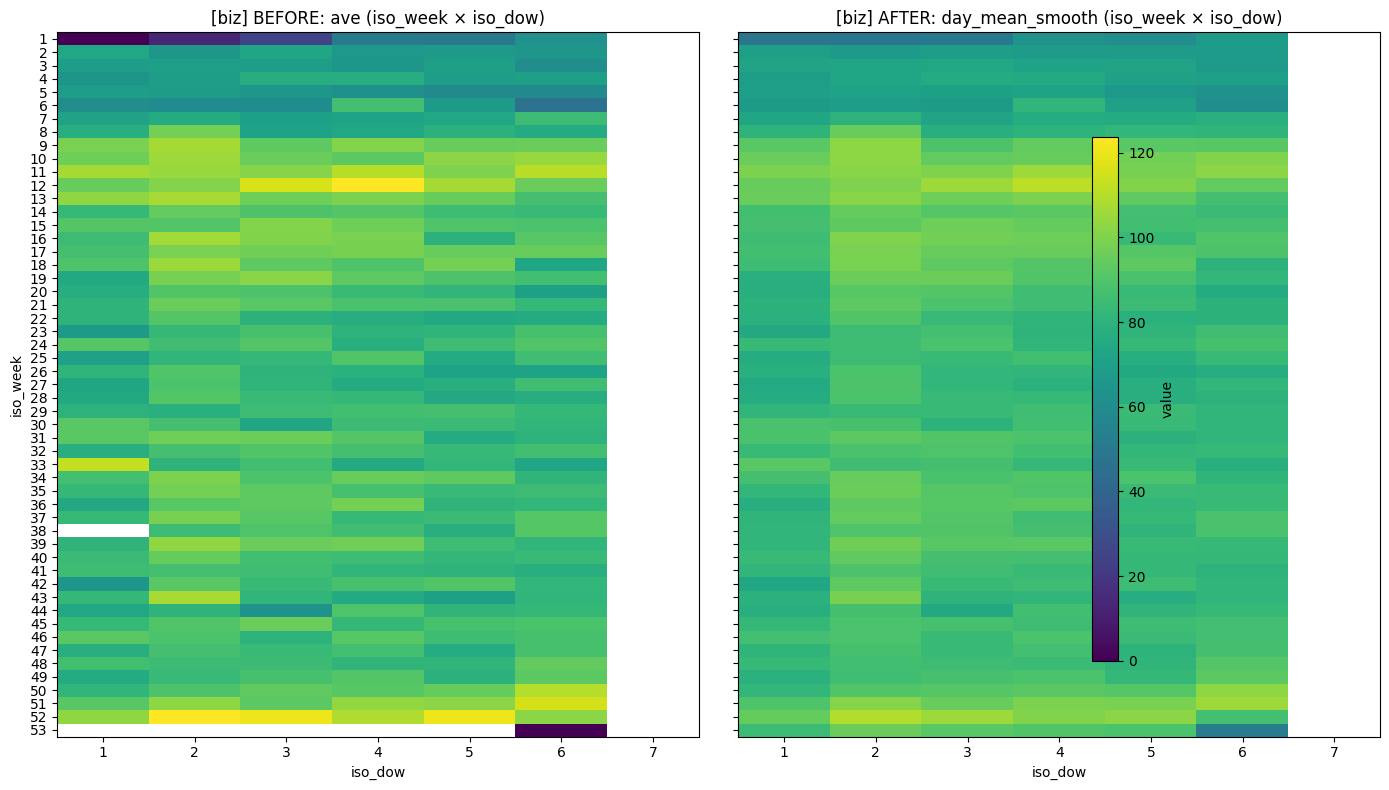

In [24]:
# 共通スケール
vmin = np.nanmin([np.nanmin(p_before.values), np.nanmin(p_after.values)])
vmax = np.nanmax([np.nanmax(p_before.values), np.nanmax(p_after.values)])

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

im0 = axes[0].imshow(p_before.values, aspect="auto", vmin=vmin, vmax=vmax)
axes[0].set_title(f"[{SCOPE}] BEFORE: ave (iso_week × iso_dow)")
axes[0].set_xlabel("iso_dow")
axes[0].set_ylabel("iso_week")
axes[0].set_xticks(range(len(DOWS)))
axes[0].set_xticklabels(DOWS)
axes[0].set_yticks(range(len(WEEKS)))
axes[0].set_yticklabels(WEEKS)

im1 = axes[1].imshow(p_after.values, aspect="auto", vmin=vmin, vmax=vmax)
axes[1].set_title(f"[{SCOPE}] AFTER: day_mean_smooth (iso_week × iso_dow)")
axes[1].set_xlabel("iso_dow")
axes[1].set_ylabel("")
axes[1].set_xticks(range(len(DOWS)))
axes[1].set_xticklabels(DOWS)
axes[1].set_yticks(range(len(WEEKS)))
axes[1].set_yticklabels(WEEKS)

cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("value")

fig.tight_layout()
plt.show()

# 保存（任意）
fig.savefig(OUT / "smooth_compare_heatmaps.png", dpi=150)


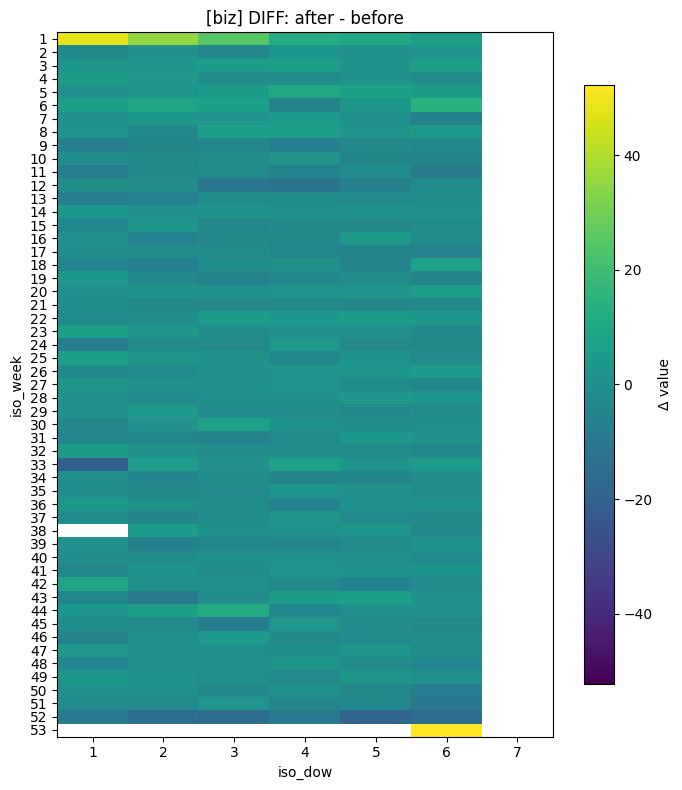

In [25]:
diff = p_after.values - p_before.values
vmax = np.nanmax(np.abs(diff))

fig, ax = plt.subplots(figsize=(7, 8))
im = ax.imshow(diff, aspect="auto", vmin=-vmax, vmax=vmax)  # カラーマップは指定しない
ax.set_title(f"[{SCOPE}] DIFF: after - before")
ax.set_xlabel("iso_dow")
ax.set_ylabel("iso_week")
ax.set_xticks(range(len(DOWS)))
ax.set_xticklabels(DOWS)
ax.set_yticks(range(len(WEEKS)))
ax.set_yticklabels(WEEKS)
cbar = fig.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label("Δ value")

fig.tight_layout()
plt.show()

# 保存（任意）
fig.savefig(OUT / "smooth_compare_diff_heatmap.png", dpi=150)


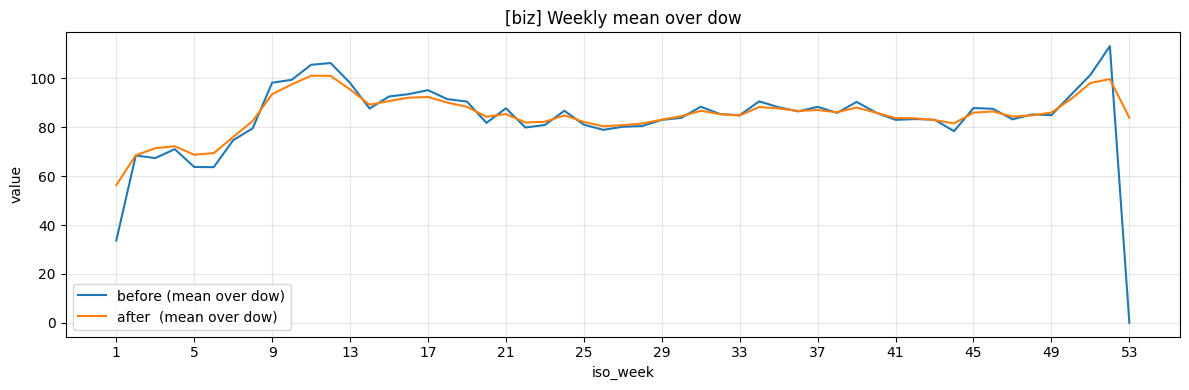

In [26]:

s_before = p_before.mean(axis=1, skipna=True)  # dow 平均 → 週系列
s_after  = p_after.mean(axis=1,  skipna=True)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(WEEKS, s_before.values, label="before (mean over dow)")
ax.plot(WEEKS, s_after.values,  label="after  (mean over dow)")
ax.set_title(f"[{SCOPE}] Weekly mean over dow")
ax.set_xlabel("iso_week")
ax.set_ylabel("value")
ax.set_xticks(WEEKS[::4])
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# 保存（任意）
fig.savefig(OUT / "smooth_compare_weekly_mean.png", dpi=150)


In [27]:
import pandas as pd

raw = pd.read_csv("/backend/app/test/out/mv_scope.csv")              # step01 出力
sm  = pd.read_csv("/backend/app/test/out/smooth_preview.csv")        # step02 出力

# biz だけを見る（all も同様に確認推奨）
raw_b = raw[raw.scope=="biz"].pivot_table(index="iso_week", columns="iso_dow", values="ave")
sm_b  = sm [sm.scope=="biz"].pivot_table(index="iso_week", columns="iso_dow", values="day_mean_smooth")

# 1) 週方向の分散がどれだけ減ったか（dowごと→平均）
std_raw = raw_b.std(axis=0, skipna=True).mean()
std_sm  = sm_b .std(axis=0, skipna=True).mean()
reduction = 1 - (std_sm/std_raw)
print(f"週方向の分散削減率: {reduction:.1%}  (目安: 20–60% 程度なら自然)")

# 2) 全体平均のズレ（大きく動いていないか）
mean_diff = (sm_b.values.mean() - raw_b.values.mean()) / raw_b.values.mean()
print(f"全体平均の相対差: {mean_diff:.2%}  (目安: ±1–2%以内)")

# 3) NaN/負値チェック
print("NaN数:", sm_b.isna().sum().sum(), "  負値数:", (sm_b<0).sum().sum())


週方向の分散削減率: 37.0%  (目安: 20–60% 程度なら自然)
全体平均の相対差: nan%  (目安: ±1–2%以内)
NaN数: 0   負値数: 0


### データ確認

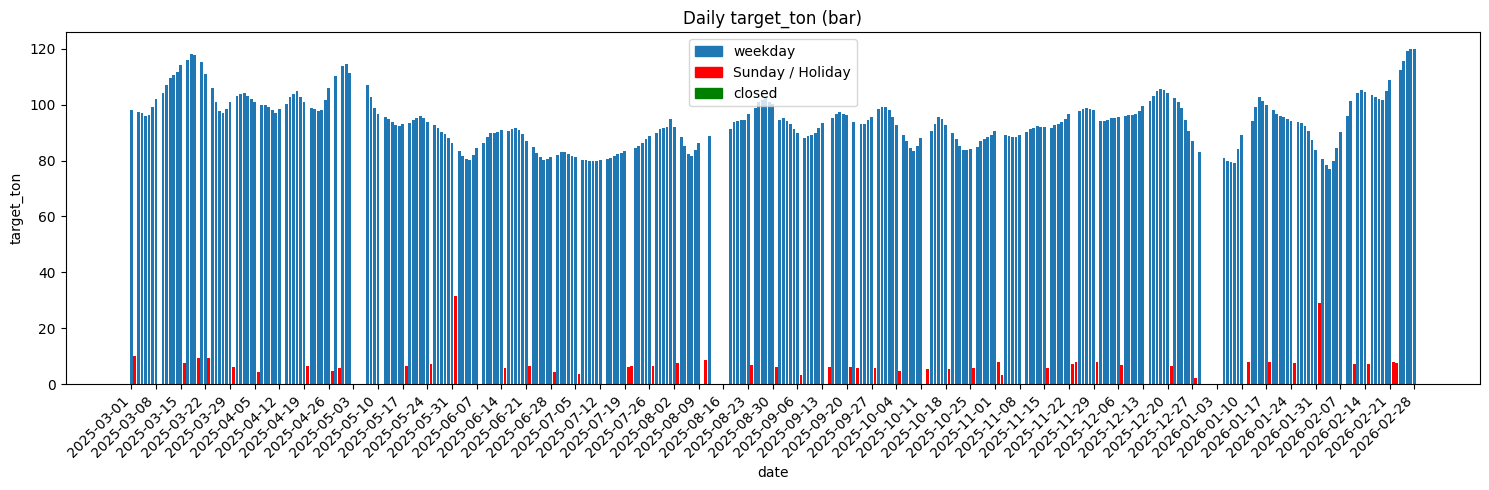

In [41]:
df_daily = pd.read_csv("/backend/app/test/out/plan_3/daily_plan.csv")
# 日付列を datetime に変換しておく（既に変換済みなら問題ありません）
df_daily = df_daily.copy()
df_daily["ddate"] = pd.to_datetime(df_daily["ddate"])

# jpholiday を使って祝日判定（なければ日曜のみ赤表示）
try:
    import jpholiday
    _has_jpholiday = True
except Exception:
    _has_jpholiday = False
    print("notice: jpholiday が見つかりません。祝日の判定は行われません。祝日も赤で表示したい場合は 'pip install jpholiday' を実行してください。")

dates = df_daily["ddate"]
# データに iso_dow（1=Mon ... 7=Sun）があればそれを使い、なければ pandas の weekday を利用
if "iso_dow" in df_daily.columns:
    is_sunday = df_daily["iso_dow"].astype(int) == 7
else:
    # pandas weekday: Monday=0 ... Sunday=6
    is_sunday = dates.dt.weekday == 6

if _has_jpholiday:
    is_holiday = dates.dt.date.map(lambda d: jpholiday.is_holiday(d))
    is_holiday = pd.Series(is_holiday.values, index=dates.index)
else:
    is_holiday = pd.Series(False, index=dates.index)

# 赤で表示する条件（日曜または祝日）
is_red = is_sunday | is_holiday

# 追加: scope_used が 'closed' の日は薄いグレーにする（閉店日等）
if "scope_used" in df_daily.columns:
    is_closed = df_daily["scope_used"] == "closed"
else:
    is_closed = pd.Series(False, index=df_daily.index)

colors = []
for i in df_daily.index:
    if is_closed.iloc[i]:
        colors.append("green")
    elif is_red.iloc[i]:
        colors.append("red")
    else:
        colors.append("C0")

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(dates, df_daily["target_ton"], width=0.8, color=colors)
ax.set_title("Daily target_ton (bar)")
ax.set_xlabel("date")
ax.set_ylabel("target_ton")

# 凡例を追加（closed が存在する場合に表示）
import matplotlib.patches as mpatches

handles = [mpatches.Patch(color='C0', label='weekday')]
if is_red.any():
    handles.append(mpatches.Patch(color='red', label='Sunday / Holiday'))
if is_closed.any():
    handles.append(mpatches.Patch(color='green', label='closed'))
ax.legend(handles=handles)

# x軸のラベルは間引いて表示（例：7日ごと）。日付が重複する場合はユニークにする
step = 7
if len(dates) > 0:
    xticks = dates.iloc[::step]
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in xticks], rotation=45, ha="right")

fig.tight_layout()
plt.show()


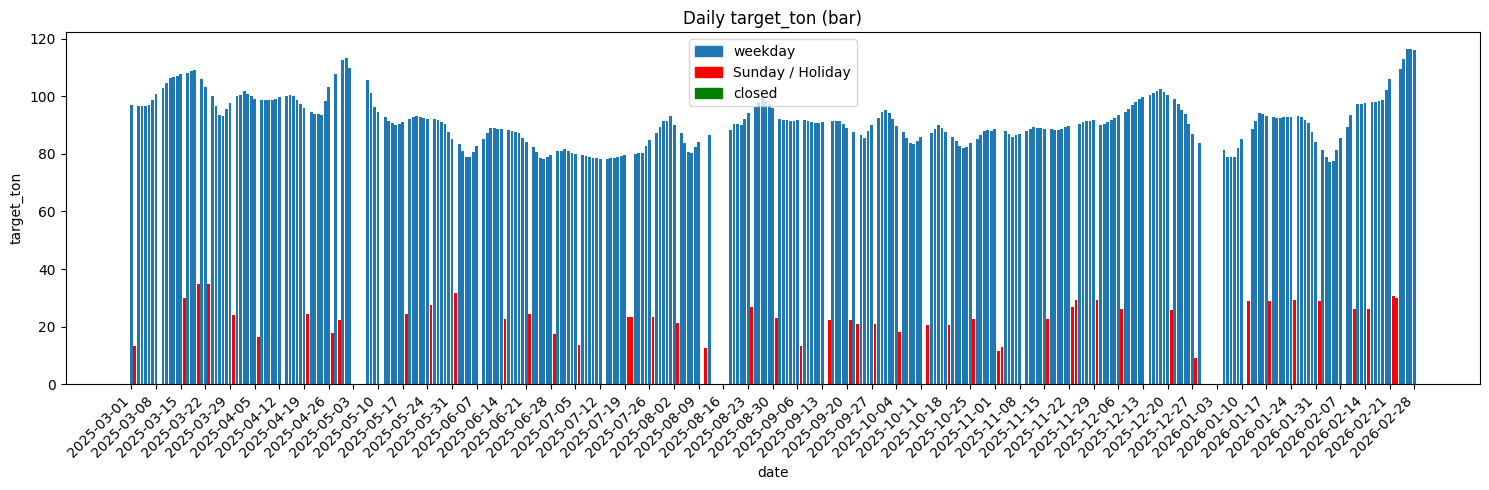

In [40]:
df_daily4 = pd.read_csv("/backend/app/test/out/plan_4/daily_plan.csv")
# 日付列を datetime に変換しておく（既に変換済みなら問題ありません）
df_daily4 = df_daily4.copy()
df_daily4["ddate"] = pd.to_datetime(df_daily4["ddate"])

# jpholiday を使って祝日判定（なければ日曜のみ赤表示）
try:
    import jpholiday
    _has_jpholiday = True
except Exception:
    _has_jpholiday = False
    print("notice: jpholiday が見つかりません。祝日の判定は行われません。祝日も赤で表示したい場合は 'pip install jpholiday' を実行してください。")

dates = df_daily4["ddate"]
# データに iso_dow（1=Mon ... 7=Sun）があればそれを使い、なければ pandas の weekday を利用
if "iso_dow" in df_daily4.columns:
    is_sunday = df_daily4["iso_dow"].astype(int) == 7
else:
    # pandas weekday: Monday=0 ... Sunday=6
    is_sunday = dates.dt.weekday == 6

if _has_jpholiday:
    is_holiday = dates.dt.date.map(lambda d: jpholiday.is_holiday(d))
    is_holiday = pd.Series(is_holiday.values, index=dates.index)
else:
    is_holiday = pd.Series(False, index=dates.index)

# 赤で表示する条件（日曜または祝日）
is_red = is_sunday | is_holiday

# 追加: scope_used が 'closed' の日は薄いグレーにする（閉店日等）
if "scope_used" in df_daily4.columns:
    is_closed = df_daily4["scope_used"] == "closed"
else:
    is_closed = pd.Series(False, index=df_daily4.index)

colors = []
for i in df_daily4.index:
    if is_closed.iloc[i]:
        colors.append("green")
    elif is_red.iloc[i]:
        colors.append("red")
    else:
        colors.append("C0")

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(dates, df_daily4["target_ton"], width=0.8, color=colors)
ax.set_title("Daily target_ton (bar)")
ax.set_xlabel("date")
ax.set_ylabel("target_ton")

# 凡例を追加（closed が存在する場合に表示）
import matplotlib.patches as mpatches

handles = [mpatches.Patch(color='C0', label='weekday')]
if is_red.any():
    handles.append(mpatches.Patch(color='red', label='Sunday / Holiday'))
if is_closed.any():
    handles.append(mpatches.Patch(color='green', label='closed'))
ax.legend(handles=handles)

# x軸のラベルは間引いて表示（例：7日ごと）。日付が重複する場合はユニークにする
step = 7
if len(dates) > 0:
    xticks = dates.iloc[::step]
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in xticks], rotation=45, ha="right")

fig.tight_layout()
plt.show()


### ゴースト

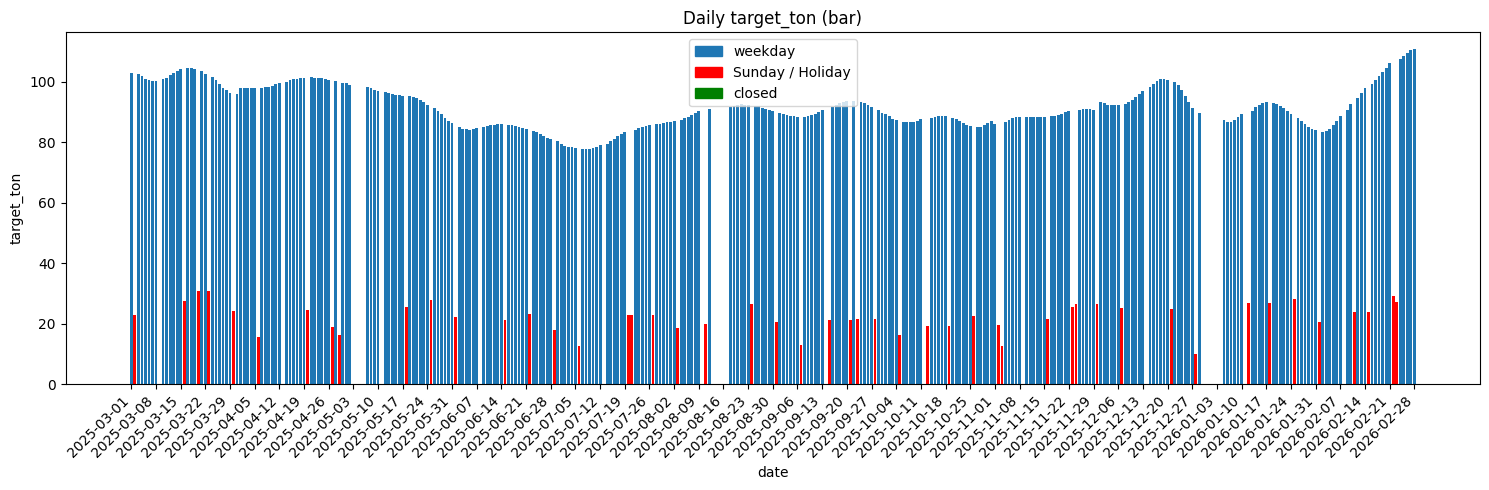

In [55]:
df_daily = pd.read_csv("/backend/app/test/out/plan/daily_plan_smooth_final.csv")
# 日付列を datetime に変換しておく（既に変換済みなら問題ありません）
df_daily = df_daily.copy()
df_daily["ddate"] = pd.to_datetime(df_daily["ddate"])

# jpholiday を使って祝日判定（なければ日曜のみ赤表示）
try:
    import jpholiday
    _has_jpholiday = True
except Exception:
    _has_jpholiday = False
    print("notice: jpholiday が見つかりません。祝日の判定は行われません。祝日も赤で表示したい場合は 'pip install jpholiday' を実行してください。")

dates = df_daily["ddate"]
# データに iso_dow（1=Mon ... 7=Sun）があればそれを使い、なければ pandas の weekday を利用
if "iso_dow" in df_daily.columns:
    is_sunday = df_daily["iso_dow"].astype(int) == 7
else:
    # pandas weekday: Monday=0 ... Sunday=6
    is_sunday = dates.dt.weekday == 6

if _has_jpholiday:
    is_holiday = dates.dt.date.map(lambda d: jpholiday.is_holiday(d))
    is_holiday = pd.Series(is_holiday.values, index=dates.index)
else:
    is_holiday = pd.Series(False, index=dates.index)

# 赤で表示する条件（日曜または祝日）
is_red = is_sunday | is_holiday

# 追加: scope_used が 'closed' の日は薄いグレーにする（閉店日等）
if "scope_used" in df_daily.columns:
    is_closed = df_daily["scope_used"] == "closed"
else:
    is_closed = pd.Series(False, index=df_daily.index)

colors = []
for i in df_daily.index:
    if is_closed.iloc[i]:
        colors.append("green")
    elif is_red.iloc[i]:
        colors.append("red")
    else:
        colors.append("C0")

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(dates, df_daily["target_ton"], width=0.8, color=colors)
ax.set_title("Daily target_ton (bar)")
ax.set_xlabel("date")
ax.set_ylabel("target_ton")

# 凡例を追加（closed が存在する場合に表示）
import matplotlib.patches as mpatches

handles = [mpatches.Patch(color='C0', label='weekday')]
if is_red.any():
    handles.append(mpatches.Patch(color='red', label='Sunday / Holiday'))
if is_closed.any():
    handles.append(mpatches.Patch(color='green', label='closed'))
ax.legend(handles=handles)

# x軸のラベルは間引いて表示（例：7日ごと）。日付が重複する場合はユニークにする
step = 7
if len(dates) > 0:
    xticks = dates.iloc[::step]
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in xticks], rotation=45, ha="right")

fig.tight_layout()
plt.show()

In [ ]:
df_daily["target_ton"]-df_daily3["target_ton"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
360    0.0
361    0.0
362    0.0
363    0.0
364    0.0
Name: target_ton, Length: 365, dtype: float64